In [23]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf

from tensorflow import feature_column
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

import os
print(tf.__version__)

2.0.1


In [2]:
# read training data
# report_id - ID to identify report
# report_params - number of parameters to execute report (when more params specified - report will be generated faster)
# day_part - when report is executed (morning, midday or afternoon) - there is less load in the morning and in the afternoon reports are generated slower
# exec_time - time spent to produce report

column_names = ['report_id','report_params','day_part','exec_time']
raw_dataframe = pd.read_csv('train/local-test/test_dir/input/report_exec_times.csv')
dataframe = raw_dataframe.copy()

dataframe.head()

,report_id,report_params,day_part,exec_time
0,1,5,2,380
1,1,4,3,450
2,1,8,2,380
3,1,6,1,320
4,1,2,2,391


In [3]:
eps=0.001 # 0 => 0.1¢
dataframe['report_params'] = np.log(dataframe.pop('report_params')+eps)

dataframe.head()

,report_id,day_part,exec_time,report_params
0,1,2,380,1.609638
1,1,3,450,1.386544
2,1,2,380,2.079567
3,1,1,320,1.791926
4,1,2,391,0.693647


In [4]:
dataframe['report_id'] = dataframe['report_id'].apply(str)
dataframe['day_part'] = dataframe['day_part'].apply(str)

dataframe.head()

,report_id,day_part,exec_time,report_params
0,1,2,380,1.609638
1,1,3,450,1.386544
2,1,2,380,2.079567
3,1,1,320,1.791926
4,1,2,391,0.693647


In [5]:
train, test = train_test_split(dataframe, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

960 train examples
240 validation examples
300 test examples


In [6]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('exec_time')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

In [7]:
feature_columns = []

feature_columns.append(feature_column.numeric_column('report_params'))

report_id = feature_column.categorical_column_with_vocabulary_list('report_id', ['1', '2', '3', '4', '5'])
report_id_one_hot = feature_column.indicator_column(report_id)
feature_columns.append(report_id_one_hot)

day_part = feature_column.categorical_column_with_vocabulary_list('day_part', ['1', '2', '3'])
day_part_one_hot = feature_column.indicator_column(day_part)
feature_columns.append(day_part_one_hot)

In [8]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

In [9]:
batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

In [10]:
# Construct neural network with Keras API on top of TensorFlow. SGD optimizer and 
# mean squared error loss to check training quality

def build_model(feature_layer):
  model = keras.Sequential([
    feature_layer,
    layers.Dense(16, activation='relu'),
    layers.Dense(16, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [11]:
model = build_model(feature_layer)

In [12]:
EPOCHS = 200
# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(train_ds,
              validation_data=val_ds,
              epochs=EPOCHS,
              callbacks=[early_stop])

Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Instructions for updating:
The old _FeatureColumn APIs are being deprecated. Please use the new FeatureColumn APIs instead.
Epoch 1/200
30/30 [==============================] - 1s 28ms/step - loss: 288222.0396 - mae: 486.7979 - mse: 288222.0312 - val_loss: 0.0000e+00 - val_mae: 0.0000e+00 - val_mse: 0.0000e+00
Epoch 2/200
30/30 [==============================] - 0s 2ms/step - loss: 285527.8299 - mae: 485.7315 - mse: 287216.0312 - val_loss: 272843.5098 - val_mae: 472.4515 - val_mse: 272955.0000
Epoch 3/200
30/30 [==============================] - 0s 2ms/step - loss: 289363.3468 - mae: 484.4510 - mse: 286026.9688 - val_loss: 271588.1855 - val_mae: 471.0588 - val_mse: 271695.3125
Epoch 4/200
30/30 [==============================] - 0s 2ms/step - loss: 284709.6079 - mae: 482.8419 - mse: 284505.5938 - val_loss: 269994.2012 - val_mae: 469.3029 - val_mse: 270097.4375
Epo

30/30 [==============================] - 0s 2ms/step - loss: 46250.1394 - mae: 166.5042 - mse: 45948.4102 - val_loss: 42918.7986 - val_mae: 158.4966 - val_mse: 43622.8359
Epoch 41/200
30/30 [==============================] - 0s 2ms/step - loss: 43976.1847 - mae: 161.8660 - mse: 43655.0625 - val_loss: 40868.6475 - val_mae: 154.8481 - val_mse: 41530.2461
Epoch 42/200
30/30 [==============================] - 0s 2ms/step - loss: 41770.6216 - mae: 158.0225 - mse: 41467.9727 - val_loss: 38909.2441 - val_mae: 150.9807 - val_mse: 39529.9102
Epoch 43/200
30/30 [==============================] - 0s 2ms/step - loss: 39473.2876 - mae: 154.0611 - mse: 39321.4297 - val_loss: 36983.9487 - val_mae: 146.8204 - val_mse: 37564.7383
Epoch 44/200
30/30 [==============================] - 0s 2ms/step - loss: 37360.2102 - mae: 149.3887 - mse: 37325.3945 - val_loss: 35209.6240 - val_mae: 143.2515 - val_mse: 35760.6406
Epoch 45/200
30/30 [==============================] - 0s 2ms/step - loss: 34564.8967 - mae: 1

Epoch 86/200
30/30 [==============================] - 0s 2ms/step - loss: 112.7715 - mae: 6.5504 - mse: 111.3757 - val_loss: 142.4956 - val_mae: 7.2374 - val_mse: 149.4196
Epoch 87/200
30/30 [==============================] - 0s 2ms/step - loss: 95.3679 - mae: 6.2479 - mse: 94.0052 - val_loss: 117.3423 - val_mae: 6.4934 - val_mse: 122.9001
Epoch 88/200
30/30 [==============================] - 0s 2ms/step - loss: 76.1128 - mae: 5.9693 - mse: 80.2235 - val_loss: 104.1469 - val_mae: 6.5815 - val_mse: 108.8036
Epoch 89/200
30/30 [==============================] - 0s 2ms/step - loss: 72.6386 - mae: 5.8316 - mse: 71.8410 - val_loss: 89.4655 - val_mae: 6.0084 - val_mse: 93.6832
Epoch 90/200
30/30 [==============================] - 0s 2ms/step - loss: 67.1196 - mae: 5.7060 - mse: 66.1227 - val_loss: 81.0936 - val_mae: 5.9231 - val_mse: 84.6006
Epoch 91/200
30/30 [==============================] - 0s 2ms/step - loss: 61.2719 - mae: 5.5989 - mse: 61.2053 - val_loss: 74.1709 - val_mae: 5.9167 - v

30/30 [==============================] - 0s 2ms/step - loss: 36.2468 - mae: 4.8584 - mse: 36.2061 - val_loss: 33.1360 - val_mae: 4.7767 - val_mse: 33.8035
Epoch 135/200
30/30 [==============================] - 0s 2ms/step - loss: 35.8924 - mae: 4.8328 - mse: 36.0505 - val_loss: 33.4289 - val_mae: 4.8749 - val_mse: 34.2413
Epoch 136/200
30/30 [==============================] - 0s 2ms/step - loss: 36.0107 - mae: 4.8490 - mse: 36.0932 - val_loss: 35.5196 - val_mae: 5.0027 - val_mse: 36.4596
Epoch 137/200
30/30 [==============================] - 0s 2ms/step - loss: 35.1765 - mae: 4.8081 - mse: 35.6735 - val_loss: 33.2646 - val_mae: 4.8336 - val_mse: 34.0142
Epoch 138/200
30/30 [==============================] - 0s 2ms/step - loss: 35.8549 - mae: 4.8292 - mse: 35.7203 - val_loss: 33.5473 - val_mae: 4.8763 - val_mse: 34.4762
Epoch 139/200
30/30 [==============================] - 0s 2ms/step - loss: 35.0210 - mae: 4.7803 - mse: 35.6573 - val_loss: 31.6813 - val_mae: 4.6790 - val_mse: 32.3997


30/30 [==============================] - 0s 3ms/step - loss: 26.1634 - mae: 4.0768 - mse: 26.0155 - val_loss: 22.8101 - val_mae: 3.9956 - val_mse: 23.5028
Epoch 183/200
30/30 [==============================] - 0s 2ms/step - loss: 25.8747 - mae: 4.0424 - mse: 25.7567 - val_loss: 22.5792 - val_mae: 3.9981 - val_mse: 23.4093
Epoch 184/200
30/30 [==============================] - 0s 2ms/step - loss: 26.1138 - mae: 4.0687 - mse: 25.9086 - val_loss: 22.8043 - val_mae: 4.0305 - val_mse: 23.5475
Epoch 185/200
30/30 [==============================] - 0s 2ms/step - loss: 26.2081 - mae: 4.0851 - mse: 25.8635 - val_loss: 22.4891 - val_mae: 3.9795 - val_mse: 23.1449
Epoch 186/200
30/30 [==============================] - 0s 2ms/step - loss: 25.2908 - mae: 4.0123 - mse: 25.3642 - val_loss: 24.6768 - val_mae: 4.2224 - val_mse: 25.4975
Epoch 187/200
30/30 [==============================] - 0s 2ms/step - loss: 25.3498 - mae: 4.0075 - mse: 25.2623 - val_loss: 22.8025 - val_mae: 3.9987 - val_mse: 23.4110


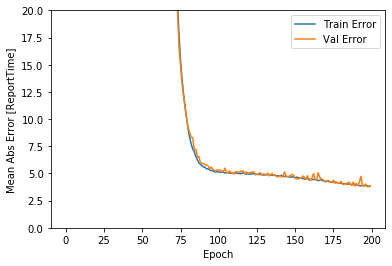

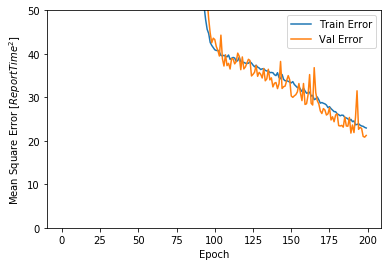

In [13]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [ReportTime]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,20])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$ReportTime^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,50])
  plt.legend()
  plt.show()


plot_history(history)

In [14]:
loss, mae, mse = model.evaluate(test_ds, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} Report Execution Time".format(mae))

Testing set Mean Abs Error:  3.62 Report Execution Time


In [15]:
# Construct test data row with "unseen" feature values - report_params = 15 

headers = ['report_id', 'report_params', 'day_part']
dataframe_input = pd.DataFrame([[1, 15, 3]],
                                columns=headers, 
                                dtype=float,
                                index=['input'])

dataframe_input.head()

,report_id,report_params,day_part
input,1.0,15.0,3.0


In [16]:
eps=0.001 # 0 => 0.1¢
dataframe_input['report_params'] = np.log(dataframe_input.pop('report_params')+eps)

dataframe_input.head()

,report_id,day_part,report_params
input,1.0,3.0,2.708117


In [19]:
dataframe_input['report_id'] = dataframe_input['report_id'].apply(str)
dataframe_input['day_part'] = dataframe_input['day_part'].apply(str)

dataframe_input.head()

,report_id,day_part,report_params
input,1.0,3.0,2.708117


In [20]:
#input_ds = df_to_dataset(dataframe_input, shuffle=False)
input_ds = tf.data.Dataset.from_tensor_slices(dict(dataframe_input))
input_ds = input_ds.batch(1)

for feature_batch in input_ds.take(1):
  for key, value in feature_batch.items():
    print("  {!r:20s}: {}".format(key, value))

  'report_id'         : [b'1.0']
  'day_part'          : [b'3.0']
  'report_params'     : [2.70811687]


In [21]:
# Prediction result for report execution time. This is correct, model learns the rule correct - more report params, means execution time will be less

res = model.predict(input_ds)
print(res)

[[215.53238]]


In [25]:
MODEL_DIR = "deploy/model_v1"
version = 1
export_path = os.path.join(MODEL_DIR, str(version))
print('export_path = {}\n'.format(export_path))
if os.path.isdir(export_path):
  print('\nAlready saved a model, cleaning up\n')
  !rm -r {export_path}

tf.saved_model.save(model, export_path)

print('\nSaved model:')
!ls -l {export_path}

export_path = deploy/model_v1/1

INFO:tensorflow:Assets written to: deploy/model_v1/1/assets

Saved model:
total 312
drwxr-xr-x 2 rmedal rmedal   4096 Mar  3 17:26 assets
-rw-r--r-- 1 rmedal rmedal 308084 Mar  3 17:26 saved_model.pb
drwxr-xr-x 2 rmedal rmedal   4096 Mar  3 17:26 variables


In [26]:
 !saved_model_cli show --dir {export_path} --all


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['__saved_model_init_op']:
  The given SavedModel SignatureDef contains the following input(s):
  The given SavedModel SignatureDef contains the following output(s):
    outputs['__saved_model_init_op'] tensor_info:
        dtype: DT_INVALID
        shape: unknown_rank
        name: NoOp
  Method name is: 

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['day_part'] tensor_info:
        dtype: DT_STRING
        shape: (-1, 1)
        name: serving_default_day_part:0
    inputs['report_id'] tensor_info:
        dtype: DT_STRING
        shape: (-1, 1)
        name: serving_default_report_id:0
    inputs['report_params'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 1)
        name: serving_default_report_params:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['output_1'] tensor_info:
       